# Praktikum Visi Komputer
## Modul ke-6

## Membuat citra panorama

Pada modul ini, kita akan mempelajari bagaimana cara menjahit/stitch beberapa citra dari scene/pemandangan yang sama untuk membuat citra panorama (*panoramic image*). Fotografi panorama merupakan teknik yang mengkombinasikan beberapa citra dari kamera yang berotasi untuk membentuk satu foto yang lebar. Ianya dapat menangkap citra secara horizontal maupun vertikal. Proses untuk mengkombinasikan banyak citra untuk menghasilkan panorama disebut sebagai *image stitching*. 


### Memadankan keypoint descriptor

Pada modul yang lalu, kita telah mempelajari cara untuk mengekstraksi keypoint menggunakan beberapa metode. Hal tersebut akan berguna pada proses pemadanan citra (*image matching*). Mari kita lihat gambar bus sekolah berikut.

[![Tkawif.md.png](https://i.im.ge/2021/09/29/Tkawif.md.png)](https://im.ge/i/Tkawif)

Kemudian gambar berikut merupakan citra yang sama namun hanya sebagian saja serta dirotasi 90 derjat berlawanan arah jarum jam. Kita sebagai manusia dengan mudahnya mengenal gambar tersebut sama sebab otak kita tidak terpengaruh (*invariant*) terhadap scaling dan rotasi. 

[![Tka6cm.md.png](https://i.im.ge/2021/09/29/Tka6cm.md.png)](https://im.ge/i/Tka6cm)

Tujuan kita di sini yaitu ingin memadankan keypoint descriptor. Berikut code programnya.

In [ ]:
#Memadankan keypoint descriptor
import sys
import cv2
import numpy as np

def draw_matches(img1, keypoints1, img2, keypoints2, matches):
    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]
    
    # Create a new output image that concatenates the two images together
    output_img = np.zeros((max([rows1,rows2]), cols1+cols2, 3), dtype='uint8')
    output_img[:rows1, :cols1, :] = np.dstack([img1, img1, img1])
    output_img[:rows2, cols1:cols1+cols2, :] = np.dstack([img2, img2, img2])
    
    # Draw connecting lines between matching keypoints
    for match in matches:
        # Get the matching keypoints for each of the images
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx
        
        (x1, y1) = keypoints1[img1_idx].pt
        (x2, y2) = keypoints2[img2_idx].pt
        
        # Draw a small circle at both co-ordinates and then draw a line
        radius = 4
        colour = (0,255,0) # green
        thickness = 1
        cv2.circle(output_img, (int(x1),int(y1)), radius, colour, thickness)
        cv2.circle(output_img, (int(x2)+cols1,int(y2)), radius, colour, thickness)
        cv2.line(output_img, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), colour, thickness)
    return output_img

if __name__=='__main__':
    #Download image: https://i.im.ge/2021/09/29/Tka6cm.png
    img1 = cv2.imread('gambar/school_bus2.png', 0) # query image (rotated subregion)
    #Download image: https://i.im.ge/2021/09/29/Tkawif.png
    img2 = cv2.imread('gambar/school_bus1.png', 0) # train image (full image)
    
    # Initialize ORB detector
    orb = cv2.ORB_create()
    
    # Extract keypoints and descriptors
    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)
    
    # Create Brute Force matcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors
    matches = bf.match(descriptors1, descriptors2)
    
    # Sort them in the order of their distance
    matches = sorted(matches, key = lambda x:x.distance)
    
    # Draw first 'n' matches
    img3 = draw_matches(img1, keypoints1, img2, keypoints2, matches[:30])
    
    cv2.imshow('Matched keypoints', img3)
    cv2.waitKey()

### Bagaimana cara kita memadankan keypoint?

Pada kode program sebelumnya, kita menggunakan detector ORB untuk melakukan ekstraksi fitur/keypoint. Setelah keypoint berhasil diekstrak, lalu kita gunakan *Brute Force matcher* untuk memadankan descriptor. Brute Force matcher ini bekerja secara sederhana yaitu dengan langsung memadankan semua descriptor pada citra pertama dengan semua descriptor pada citra kedua, dan kita pilih yang terdekat. Untuk memilih descriptor yang terdekat, di sini kita gunakan jarak Hamming sebagai metric pengukuran:

`bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)`

Argumen kedua yaitu variabel Boolean. Jika bernilai True, maka *matcher* hanya mengembalikan keypoint yang terdekat dari keduanya. Hal ini bermakna jika ada (i,j) sebagai padanan, maka kita bisa pastikan bahwa descriptor ke-i pada citra pertama memiliki padanan terdekat descriptor ke-j pada citra kedua, begitu juga sebaliknya. Hal ini akan meningkatkan konsistensi dan kehandalan dari *descriptor matching*


### Memahami objek matcher

Perhatikan baris berikut:

`matches = bf.match(descriptors1, descriptors2)`

Variabel matches akan menyimpan objek DMatch. Jika kita melakukan iterasi pada objek Dmatch, maka setiap item memiliki atribut:
- item.distance: atribut ini mengembalikan jarak antara descriptor. Jarak yang singkat mengindikasikan padanan yang lebih baik
- item.trainIdx: atribut ini mengembalikan indeks dari descriptor pada data list descriptor latihan (pada contoh di atas, list descriptor dari citra yang lengkap)
- item.queryIdx: atribut ini mengembalikan index dari descriptor pada data list descriptor query (pada contoh di atas, list descriptor dari potongan bus terbalik)
- item.imgIdx: atribut ini mengembalikan indeks dari citra latih. 


### Menggambar keypoint yang sepadan 

Sesudah kita paham bagaimana cara mengakses atribut-atribut pada objek matcher, maka atribut itu dapat digunakan untuk menggambar keypoint yang sepadan. Sebenarnya OpenCV 3.0 sudah menyediakan fungsi yang dapat langsung menggambar keypoint yang sepada. Namun pada contoh di atas, diberikan langkah-langkah penggambarannya.

Pertama dibuat satu citra besar yang dapat memuat kedua gambar secara bersisian. 

`output_img = np.zeros((max([rows1,rows2]), cols1+cols2, 3), dtype='uint8')`

Pada kode program di atas, banyaknya baris diberikan nilai yang lebih besar dari 2 nilai baris yang masing-masing berasal dari citra latih dan citra query. Sedangkan banyaknya kolom merupakan jumlah dari 2 nilai kolom yang berasal dari kedua citra. Kemudian, untuk setiap list item yang sepadan, kita ekstrak lokasi dari keypoint yang sepadan, seperti pada kode berikut:

`(x1, y1) = keypoints1[img1_idx].pt
(x2, y2) = keypoints2[img2_idx].pt`

Berikutnya kita tinggal menggambar lingkaran pada titik tersebut untuk menunjukkan lokasinya dan menggambar garis yang menghubungkan kedua titik.


### Membuat citra panorama 

Setelah kita membahas tentang keypoint dan padanannya, maka kita akan gunakan hal tersebut dalam membuat citra panorama. Jadi di sini kita akan bekerja dengan citra yang berasal dari pemandangan pada kawasan yang sama namun memiliki bagian yang mirip. Sehingga dengan menggunakan bagian yang mirip tersebut maka kita akan melakukan *image stitching* untuk menghasilkan citra panorama.

Untuk membuat citra panorama, terdapat beberapa hal yang perlu dilakukan seperti:
- deteksi keypoint 
- local invariant descriptors (seperti SIFT, SURF, ORB)
- feature matching (pemadanan fitur/keypoint)
- estimasi homography menggunakan RANSAC
- perspective warping

In [ ]:
#import library, jika ada yg belum ada pada komputer anda, maka lakukan pip install

import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)

In [ ]:
# default di sini yang digunakan adalah orb dan bf
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

In [ ]:
# Baca citra dan ubah jadi grayscale
# Pastikan citra latih (train image) adalah citra yang ingin diubah 
# download gambar di: https://i.im.ge/2021/09/30/THZJwf.png
trainImg = imageio.imread('gambar/house2.png')
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

# download gambar di https://i.im.ge/2021/09/30/THWiP8.png
queryImg = imageio.imread('gambar/house1.png')
# Opencv menggunakan channel warna dengan urutan BGR 
# Maka kita ubah ke RGB supaya kompatibel dengan matplotlib
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

In [ ]:
#fungsi untuk memastikan algoritma fitur descriptor yang akan digunakan
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

In [ ]:
#dapatkan keypoint dan fitur dari citra latih dan citra query
kpsA, featuresA = detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(queryImg_gray, method=feature_extractor)

In [ ]:
# tampilkan keypoint dan fitur yang terdeteksi pada kedua citra
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

In [ ]:
#Fungsi untuk memastikan brute force dengan algoritma distance apa yang akan digunakan
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [ ]:
#Fungsi untuk memadankan fitur dari kedua citra lalu mengurutkan berdasarkan jarak
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

In [ ]:
#Fungsi menggunakan algoritma kNN untuk memilih jarak terdekat, di sini dipakai k=2
def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

In [ ]:
#Fungsi untuk menggambar padanan fitur
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.show()

In [ ]:
#Fungsi untuk mencari homografi berdasarkan padanan fitur yang ditemukan 
#dengan mengambil titik-titik dari kedua citra dan mengekstrak matriks transformasi
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [ ]:
#Memanggil fungsi homografi
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

In [ ]:
# Menampilkan citra panorama
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

In [ ]:
# Mengubah citra panorama menjadi grayscale lalu memotongnya/crop berdasarkan threshould dari kontur  
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)

In [ ]:
#Latihan 1
#Simpan gambar yang anda hasilkan sebelumnya kemudian lakukan image stitching dengan 
#citra berikut: https://i.im.ge/2021/09/30/THVNLz.png
#Sesudah image stitching, crop image berdasarkan konturnya.
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)

feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

trainImg = imageio.imread('gambar/house3.png')
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)
queryImg = imageio.imread('gambar/house1.png')
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

kpsA, featuresA = detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(queryImg_gray, method=feature_extractor)

def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None
    
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M

width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

# Mengubah citra panorama menjadi grayscale lalu memotongnya/crop berdasarkan threshould dari kontur  
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)

Raw matches (Brute force): 162


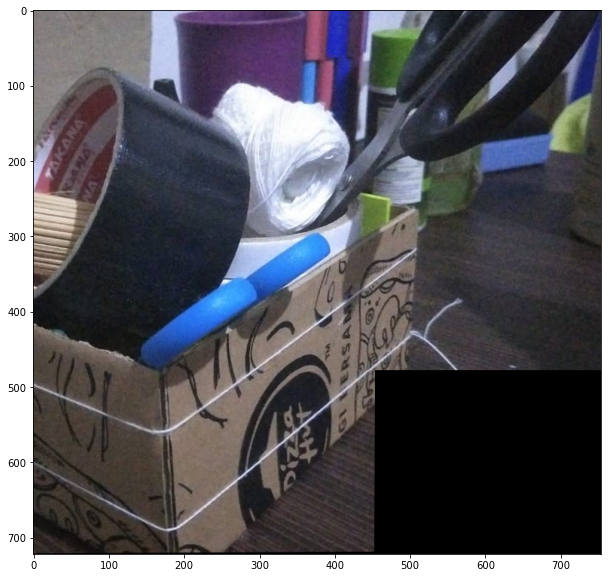

In [10]:
#Latihan 2
#Ambil foto pemandangan sekitar anda menggunakan kamera HP, ambil 2 atau 3 gambar 
#dengan pemandangan yang sama dengan bagian yang mirip, lalu lakukan image stitching dan 
#crop image

import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)

feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

trainImg = imageio.imread('gambar/perkakas1.jpeg')
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)
queryImg = imageio.imread('gambar/perkakas2.jpeg')
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

kpsA, featuresA = detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(queryImg_gray, method=feature_extractor)

def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None
    
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M

width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

# Mengubah citra panorama menjadi grayscale lalu memotongnya/crop berdasarkan threshould dari kontur  
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)